Improvements over binary classifier:

- removed unused graphviz import
- define labels to classify: simply encode (no) vandalism according to a set of labels
- use features computed by rev 5f03bf5 of the vandalism detector, includes revision ID
- use DataFrame - it works the same and retains column labels etc.
- added plt.show() to error analysis to draw matrix
- add example FP and FN (= misclassified revisions)
- added plot for FP frequency per tag


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import HTML, display

In [140]:
np.random.seed(4222968274)

In [141]:
# Import dataset
df = pd.read_csv('./data/features_modified_total6100.csv')
tag_df = pd.read_csv('./data/tag.csv')
labels = df.columns
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,authorRank,authorRankOfLast200Edits,authorRankOneMonth,...,LZWCompressionRate,KLDOfCharDistribution,commentLength,userCommentLength,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,revision_id,tag_id
0,1.0,0.0,2.0,21.0,2.0,1.0,0.0,-1.0,-1.0,-1.0,...,0.338064,5.563610,14.0,14.0,0.0,0.0,0.0,0.0,721792503,6
1,1.0,0.0,6.0,2.0,4.0,4.0,0.0,-1.0,-1.0,-1.0,...,0.287100,515.060308,20.0,20.0,0.0,0.0,0.0,0.0,287001519,6
2,1.0,0.0,19.0,14.0,2.0,2.0,0.0,-1.0,-1.0,-1.0,...,0.327554,0.000000,0.0,0.0,0.0,0.0,2.0,0.0,139272254,6
3,1.0,0.0,20.0,2.0,6.0,7.0,0.0,-1.0,-1.0,-1.0,...,0.555396,367.149974,12.0,12.0,0.0,0.0,0.0,0.0,536243596,6
4,1.0,0.0,13.0,8.0,5.0,5.0,0.0,-1.0,-1.0,-1.0,...,0.352716,7.933723,7.0,7.0,0.0,0.0,0.0,0.0,321571480,6


In [142]:
# Encode vandalism or no vandalism according to tags-of-interest
TAG_IDS = [6]
df['is_vandalism'] = df.tag_id.isin(TAG_IDS)
tag_df

,id,name
0,1,Blanking
1,2,Nonsense
2,3,QualityIssue
3,4,PersonalStory
4,5,FalseFacts
5,6,Syntax
6,7,MergeConflict
7,8,Template
8,9,EditWars
9,10,SEO


In [143]:
X = df
y = df['is_vandalism']
labels = X.columns

In [144]:
# Undersample class of 'constructive' samples
sampler = RandomUnderSampler()
X_resampled, y_resampled = sampler.fit_sample(X, y)

# Convert sampler output to DF - rescue column names etc.
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

# Split dataset into training and test
X_train_complete, X_test_complete, y_train, y_test = train_test_split(X_resampled, y_resampled)

# Truncate metadata columns
feature_columns = [x for x in X.columns if x not in ['is_vandalism', 'tag_id', 'revision_id']]
X_train = X_train_complete[feature_columns]
X_test = X_test_complete[feature_columns]

print('Train X', X_train.shape)
print('Train y', y_train.shape)

print('Test X', X_test.shape)
print('Test y', y_test.shape)

Train X (69, 82)
Train y (69,)
Test X (23, 82)
Test y (23,)


In [145]:
# Build model and evaluate parameters using crossvalidation
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs = -1)

scores = cross_validate(clf, X_train, y_train,
                        scoring=['f1', 'precision', 'recall', 'roc_auc', 'accuracy'],
                        cv=3, return_train_score=False)    

print('Training scores:')
for name, values in scores.items():
    print(name, ": %0.2f (+/- %0.2f)" % (values.mean(), values.std() * 2))

Training scores:
fit_time : 0.31 (+/- 0.11)
score_time : 0.53 (+/- 0.01)
test_f1 : 0.69 (+/- 0.17)
test_precision : 0.62 (+/- 0.04)
test_recall : 0.79 (+/- 0.35)
test_roc_auc : 0.78 (+/- 0.01)
test_accuracy : 0.67 (+/- 0.08)


In [146]:
# Evaluate model parameters: Confusion matrix
columns = ['Predicted No Vandalism', 'Predicted Vandalism']
index = ['True No Vandalism', 'True Vandalism']
classes = ['No Vandalism', 'Vandalism']

y_train_predict = cross_val_predict(clf, X_train, y_train, cv=3)
cf_matrix = confusion_matrix(y_train, y_train_predict)

print('Training scores:')
pd.DataFrame(cf_matrix, columns=columns, index=index)

Training scores:


,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,22,13
True Vandalism,10,24


In [147]:
# Evaluate model parameters: Classification report
print('Training scores:')
print(classification_report(y_train, y_train_predict, target_names=classes))

Training scores:
              precision    recall  f1-score   support

No Vandalism       0.69      0.63      0.66        35
   Vandalism       0.65      0.71      0.68        34

 avg / total       0.67      0.67      0.67        69



In [148]:
# Train model
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
y_predict_prob = clf.predict_proba(X_test)
y_predict_vandalism = y_predict_prob[:,1]

In [149]:
y_predict_vandalism[10]

0.38

Precision and recall scores:


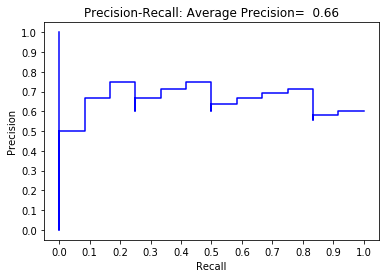

PR-AUC 0.6172354205248943


In [150]:
# Evaluate model: Precision & Recall
print('Precision and recall scores:')

precision, recall, thresholds = precision_recall_curve(y_test, y_predict_vandalism)
average_precision = average_precision_score(y_test, y_predict_vandalism)

plt.title('Precision-Recall: Average Precision=  %0.2f' % average_precision)
plt.step(recall, precision, color='b', where='post')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

print("PR-AUC", auc(recall, precision))

In [151]:
# Evaluate model: Confusion matrix
columns = ['Predicted No Vandalism', 'Predicted Vandalism']
index = ['True No Vandalism', 'True Vandalism']

print('Final model scores:')
pd.DataFrame(confusion_matrix(y_test, y_predict), columns=columns, index=index)

Final model scores:


,Predicted No Vandalism,Predicted Vandalism
True No Vandalism,7,4
True Vandalism,6,6


In [152]:
# Evaluate model: Classification report
print('Final model scores:')
print(classification_report(y_test, y_predict, target_names=classes))

Final model scores:
              precision    recall  f1-score   support

No Vandalism       0.54      0.64      0.58        11
   Vandalism       0.60      0.50      0.55        12

 avg / total       0.57      0.57      0.56        23



Final model scores:
roc_auc 0.6893939393939393


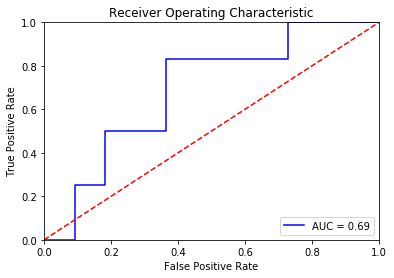

In [153]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict_vandalism)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('Final model scores:')
print('roc_auc', roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

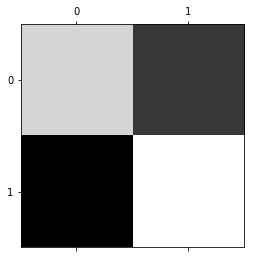

In [154]:
# Error analysis
y_train_predict = cross_val_predict(clf, X_train, y_train, cv=3)
cf_matrix = confusion_matrix(y_train, y_train_predict)

plt.matshow(cf_matrix, cmap=plt.cm.gray)
plt.show()

In [155]:
# Showing some instances not classifed correctly

# False Negatives for the test set
fn_test = X_test_complete[(y_test == 1) & (y_predict == 0)]
fn_with_labels = fn_test.merge(tag_df, how='left', left_on='tag_id', right_on='id')
#fn_with_labels[['revision_id', 'tag_id', 'name']]

fn_html = []
for _, item in fn_with_labels.iterrows():
    item_html = """
        {tag}: 
        <a href="http://en.wikipedia.org/w/index.php?diff={rev_id}">
          {rev_id} 
        </a>
    """.format(rev_id=int(item['revision_id']), tag=item['name'])
    fn_html.append(item_html)
display(HTML(',&nbsp;'.join(fn_html)))

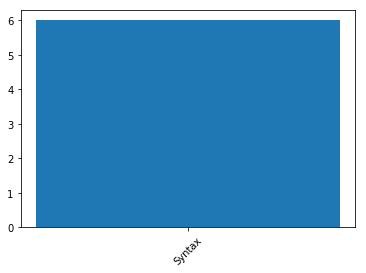

In [156]:
fn_tag_counts = fn_with_labels.name.value_counts()
fn_tag_x = np.arange(len(fn_tag_counts))
plt.bar(fn_tag_x, fn_tag_counts.values)
plt.xticks(fn_tag_x, fn_tag_counts.index, rotation=45)
plt.show()

In [157]:
# False Positives for the test set
fp_test = X_test_complete[(y_test == 0) & (y_predict == 1)]
fp_with_labels = fp_test.merge(tag_df, how='left', left_on='tag_id', right_on='id')
fp_with_labels[['revision_id', 'tag_id', 'name']]

,revision_id,tag_id,name
0,586811243.0,11.0,Intention
1,543863782.0,11.0,Intention
2,141060584.0,12.0,constructive
3,476528714.0,12.0,constructive


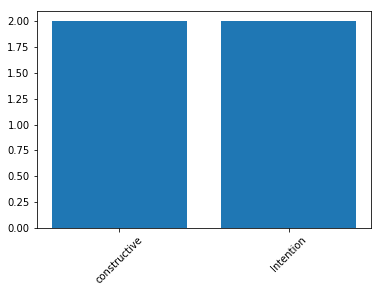

In [158]:
fp_tag_counts = fp_with_labels.name.value_counts()
tag_x = np.arange(len(fp_tag_counts))
plt.bar(tag_x, fp_tag_counts.values)
plt.xticks(tag_x, fp_tag_counts.index, rotation=45)
plt.show()

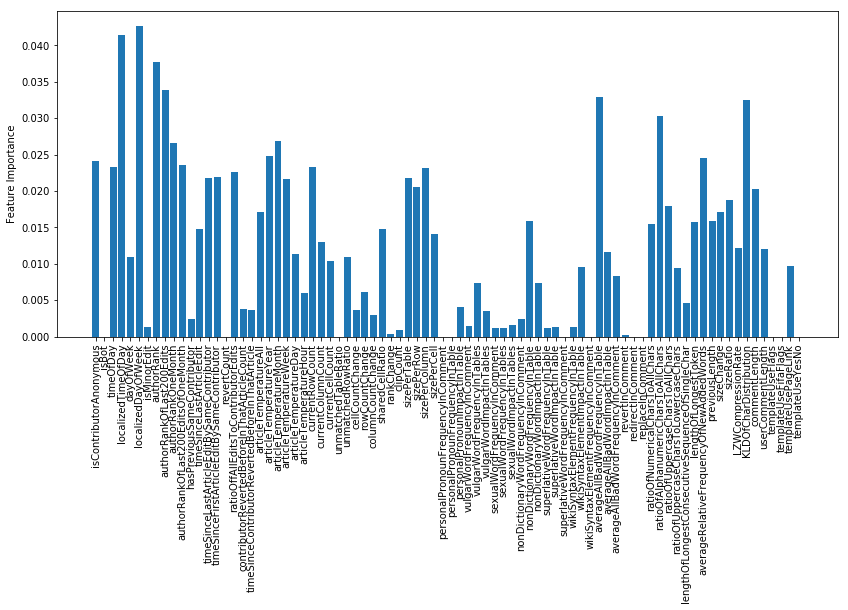

In [159]:
# Feature importance (weights in random forrest)
feature_importance = clf.feature_importances_
feature_labels = X_train.columns
x_pos = np.arange(len(feature_importance)) 

plt.gcf().set_size_inches(14, 6)
plt.bar(x_pos, feature_importance,align='center')
plt.xticks(x_pos, feature_labels, rotation='vertical') 
plt.ylabel('Feature Importance')
plt.show()